# Notebook to plot firing rate correlation between stimulus and delay phases.

In [ ]:
"""Imports."""

from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [34]:
"""Load data."""

_BASE_DATA_DIR = Path('../../../cache/phys_processing/spikes_to_trials')
_DELAY_DATA_DIR = _BASE_DATA_DIR / 'delay_phase_firing_rates'
_STIMULUS_DATA_DIR = _BASE_DATA_DIR / 'stimulus_phase_firing_rates'
_PROBE_TO_BRAIN_AREA = {
    "s0": "DMFC",
    "vprobe0": "FEF",
    "vprobe1": "FEF",
}
dataframes = []
for subject_dir in _DELAY_DATA_DIR.iterdir():
    subject = subject_dir.name
    if subject.startswith('.'):
        continue
    for session_dir in subject_dir.iterdir():
        session = session_dir.name
        if session.startswith('.'):
            continue
        df_delay = pd.read_csv(session_dir / "fr.csv")
        df_stimulus = pd.read_csv(_STIMULUS_DATA_DIR / subject / session / "fr.csv")
        unit_to_brain_area = dict(zip(df_delay['unit'], df_delay['probe']))
        unit_to_brain_area = {
            unit: _PROBE_TO_BRAIN_AREA[probe]
            for unit, probe in unit_to_brain_area.items()
        }

        # Take average firing rates over trials
        df_delay_avg = df_delay.groupby('unit')['firing_rate'].mean().reset_index()
        df_stimulus_avg = df_stimulus.groupby('unit')['firing_rate'].mean().reset_index()

        # Rename "firing_rate" column
        df_delay_avg = df_delay_avg.rename(columns={'firing_rate': 'Mean delay firing rate (Hz)'})
        df_stimulus_avg = df_stimulus_avg.rename(columns={'firing_rate': 'Mean stimulus firing rate (Hz)'})

        # Merge delay and stimulus dataframes
        df = pd.merge(df_delay_avg, df_stimulus_avg, on='unit', how='outer')
        df['subject'] = subject
        df['session'] = session
        df['task'] = df_delay['task'].values[0]
        df['Brain Area'] = df['unit'].map(unit_to_brain_area)

        dataframes.append(df)
df = pd.concat(dataframes, ignore_index=True)

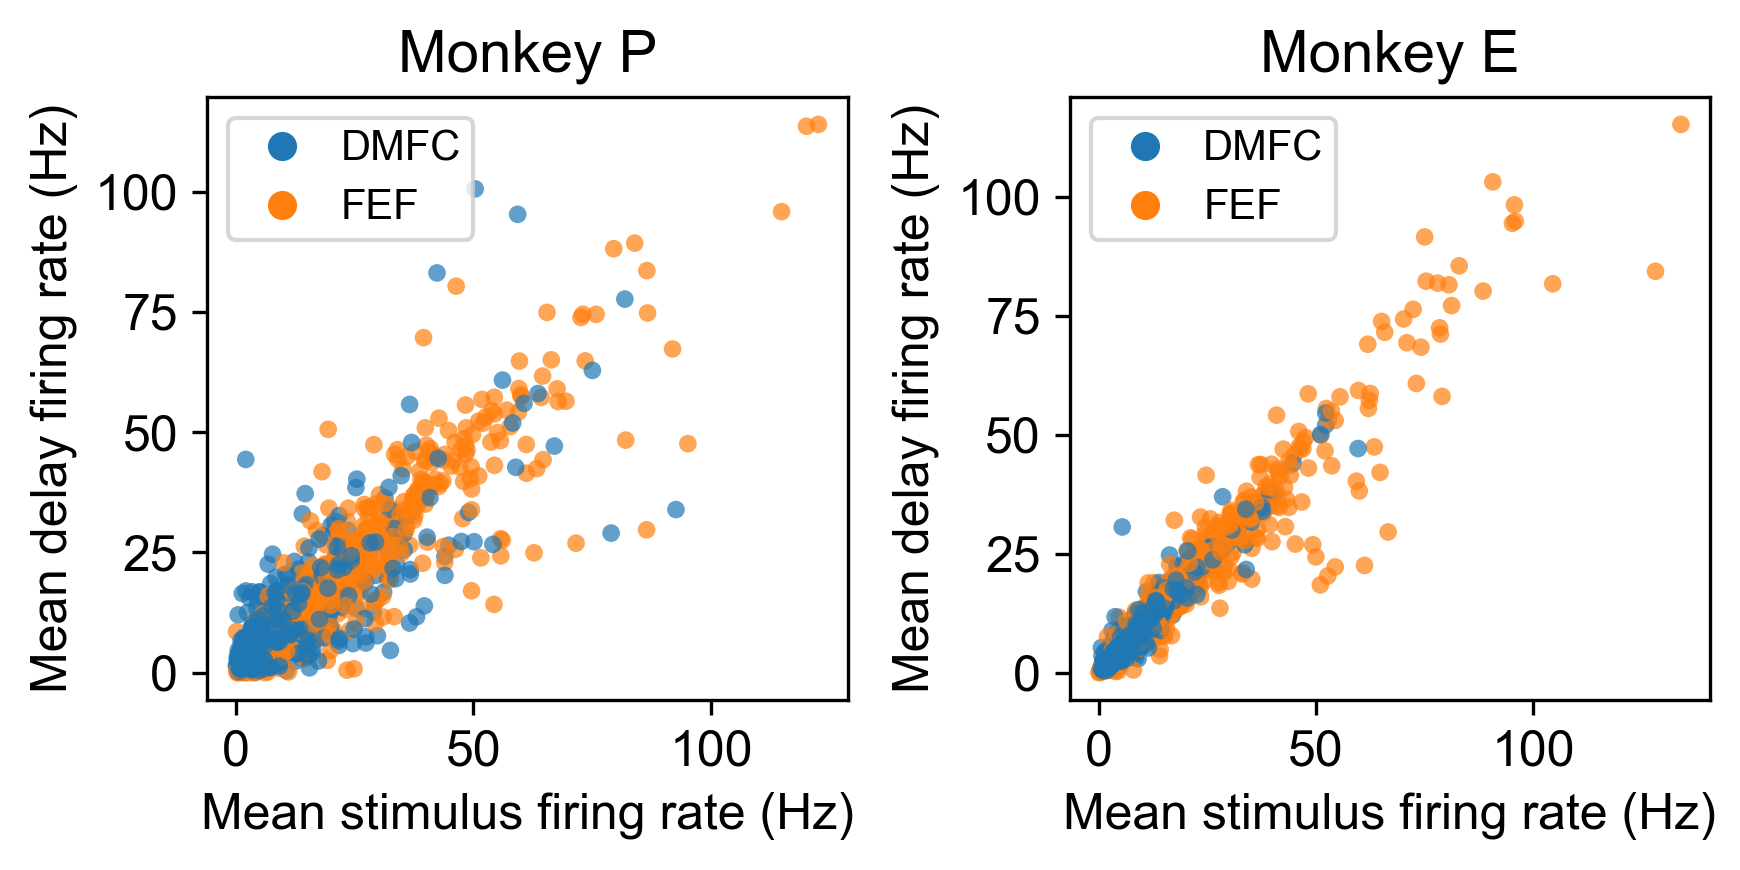

In [64]:
"""Plot correlation between stimulus and delay firing rates."""

fig, axes = plt.subplots(1, 2, figsize=(5.9, 3))
for ax, subject in zip(axes, ["Perle", "Elgar"]):
    df_subject = df[
        (df['subject'] == subject) &
        (df['task'] == 'triangle')
    ]
    sns.scatterplot(
        data=df_subject,
        x='Mean stimulus firing rate (Hz)',
        y='Mean delay firing rate (Hz)',
        hue='Brain Area',
        ax=ax,
        alpha=0.7,
        linewidth=0,
        s=18,
        legend=False,
        hue_order=['DMFC', 'FEF'],
    )
    ax.set_title(f"Monkey {subject[0].capitalize()}")

# Make custom legend
handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=brain_area,
        markerfacecolor=sns.color_palette()[i],
        markersize=8,
    )
    for i, brain_area in enumerate(['DMFC', 'FEF'])
]
for ax in axes:
    ax.legend(
        handles=handles,
        loc='upper left',
        ncol=1,
        handletextpad=0.4,
        borderpad=0.3,
    )
# Save figure
fig.tight_layout()
fig.savefig('./firing_rate_correlation.pdf', bbox_inches='tight', pad_inches=0.01)